# Brokerage Business - Case Study

## Introduction 
Analyze KPIs such as turnover, management fee and and yield. These KPIs have decreased over the years. 

## Import libraries 


In [1]:
# Run the chown command to chagne the ownership
!sudo chown -R jupyter:jupyter /home/jupyter

In [2]:
# Install the Google Cloud BigQuery library
!pip install --user google-cloud-bigquery

**Restart** the kernel before proceeding further. 



In [3]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

## KPIs for entire customer base

First, let's verify the claim that "important KPIs have been decreasing". <br><br> There are 3 metrics, turnover, management fees and yield. Let's look at them one by one. 



## Turnover

For individual customers, turnover is defined as <br>
<blockquote>Turnover = Traded value / Market Value in Brokerage </blockquote>

To get a general feeling of the data, we calculate **total_turnover**, which is <br>
<blockquote>Total Turnover = Traded value for all customers / Market Value in Brokerage for all customers </blockquote>

We also calculate **total_management_fee** and **total_yields**. 

In [4]:
%%bigquery total_kpis
## Find total  turnover, management fees and yield. 
SELECT 
    c.Year
    ,SUM(Traded_value_Brokerage) AS total_traded_value_brokerage
    ,SUM(Market_value_Brokerage) AS total_market_value_brokerage
    ,SUM(Traded_value_Brokerage) / SUM(Market_value_Brokerage) AS total_turnover
    ,SUM(Net_income_Managed_assets) AS total_net_income_managed_assets
    ,SUM(Market_value_Managed_assets) AS total_market_value_managed_assets
    ,SUM(Net_income_Managed_assets) / SUM(Market_value_Managed_assets) AS total_mgt_fee
    ,SUM(Net_income_Net_interest) AS total_net_income_net_interest
    ,SUM(Deposits) AS total_deposits
    ,SUM(Net_income_Net_interest) / SUM(Deposits) AS total_yield
FROM 
    `insight-candidate-11.case_data.Customer` as c
    JOIN `insight-candidate-11.case_data.Financial` as f 
        ON f.CustomerNumber = c.CustomerNumber AND f.Year = c.Year
GROUP BY 
    c.Year
;

In [5]:
total_kpis

,Year,total_traded_value_brokerage,total_market_value_brokerage,total_turnover,total_net_income_managed_assets,total_market_value_managed_assets,total_mgt_fee,total_net_income_net_interest,total_deposits,total_yield
0,2018,4.744424e+09,1.234295e+10,0.384383,1148555.1,2.614924e+09,0.000439,1.668603e+06,2.891015e+09,0.000577
1,2019,4.394656e+09,1.258092e+10,0.349311,1285072.5,3.312460e+09,0.000388,1.475976e+06,3.240363e+09,0.000455
2,2020,3.748484e+09,1.256598e+10,0.298304,1612005.8,3.990234e+09,0.000404,8.269809e+05,4.168810e+09,0.000198


## Visualize the turnover year over year

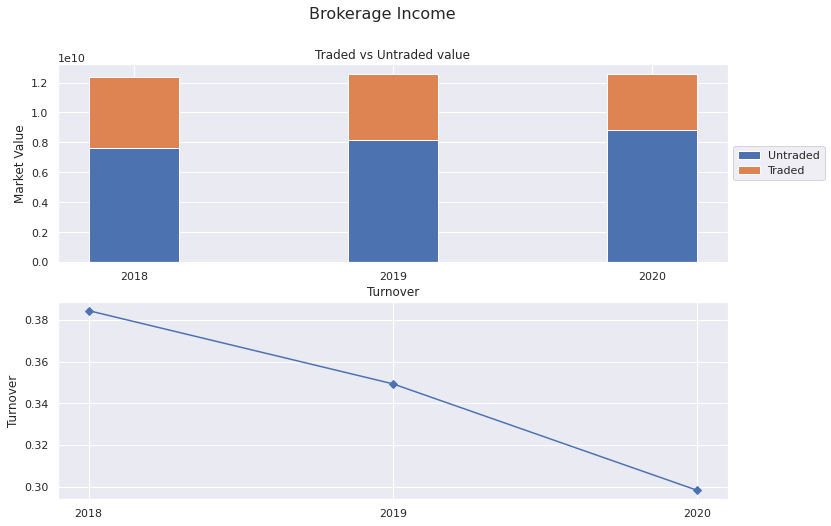

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(12, 8)

width = 0.35
years = total_kpis["Year"]
untraded = total_kpis["total_market_value_brokerage"] - total_kpis["total_traded_value_brokerage"]

ax1.bar(years, untraded, label= "Untraded", width=width)
ax1.bar(years, total_kpis["total_traded_value_brokerage"], bottom=untraded, label= "Traded", width=width)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xticks(years)
ax1.set_ylabel("Market Value")
ax1.set_title("Traded vs Untraded value")

ax2.plot(years, total_kpis["total_turnover"], marker="D")
ax2.set_xticks(years)
ax2.set_ylabel("Turnover")
ax2.set_title("Turnover")

fig.suptitle('Brokerage Income', fontsize=16)

plt.show()

**Conclusion**: We can see that the total market value is increasing year over year, as well as the traded value. However, the turnover rate is decreasing. 

## Management Fee and Yield

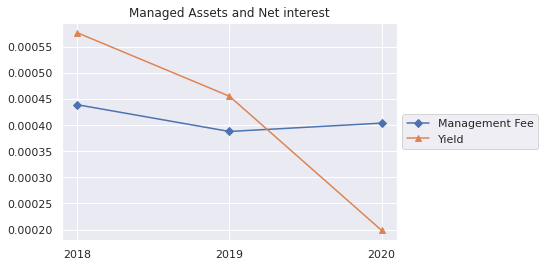

In [7]:
fig, ax = plt.subplots()
years = total_kpis["Year"]

ax.plot(years, total_kpis["total_mgt_fee"], label="Management Fee",  marker="D")
ax.plot(years, total_kpis["total_yield"], label="Yield",  marker="^")

ax.set_title("Managed Assets and Net interest")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(years)

plt.show()

**Conclusion**: We can see that management fee and yields have been decreasing as well. 

## A deeper look into turnover

Let's focus on the Brokerage business and try to find out which factor contributed to the decrease in turnover. 


### Avoid Divid by Zero
Turnover is calculated in this way 
<blockquote>Turnover = Traded value / Market Value in Brokerage </blockquote>

In order to avoid "Divid by Zero" error, let's find out how may customers have traded, but with market_value_brokerage as 0


In [8]:
%%bigquery zero_customers
SELECT 
    c.Year
    ,CustomerCountry
    ,CustomerGender
    ,CustomerAge
    ,CustomerDuration
    ,f.Traded_value_Brokerage
    ,f.Market_value_Brokerage
    --,SAFE_DIVIDE(Traded_value_Brokerage, Market_value_Brokerage) AS turnover
FROM 
    `insight-candidate-11.case_data.Customer` as c
    JOIN `insight-candidate-11.case_data.Financial` as f 
        ON f.CustomerNumber = c.CustomerNumber AND f.Year = c.Year
WHERE
    f.Traded_value_Brokerage > f.Market_value_Brokerage
    AND f.Market_value_Brokerage = 0.0
    AND f.YEAR = 2019
;

In [9]:
zero_customers.head()

,Year,CustomerCountry,CustomerGender,CustomerAge,CustomerDuration,Traded_value_Brokerage,Market_value_Brokerage
0,2019,DK,M,18,< 1 year as customer,53406.86,0.0
1,2019,DK,M,18,1-3 years as customer,1147.67,0.0
2,2019,DK,M,18,< 1 year as customer,131.58,0.0
3,2019,DK,M,19,< 1 year as customer,271.33,0.0
4,2019,DK,M,19,< 1 year as customer,208.55,0.0


In [10]:
len(zero_customers)

1033

There are quite a few of them. Why?
* Maybe they traded lots of assets, made profits by closing all of their positions. Therefore, the current market value is zero. 
* Maybe they traded lots of assets, lost lots of money. They stopped trading and emptyed their account. 

Visualzing those customers by age group, we can see that most of them are concentrated in the younger age group. 

**Conclusion**: Instead of making those assemptions by ourselves, we'd better talk to the domain experts to find out why. 

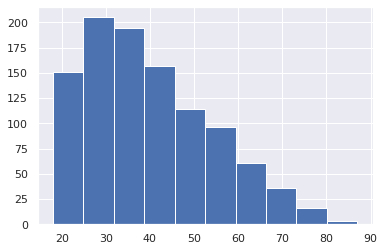

In [11]:
plt.hist(zero_customers["CustomerAge"])
plt.show()

### Throwing away outliers

Now we create two tables, excluding rows where *trade_value_brokerage* or *market_value_brokerage* is 0

In [12]:
%%bigquery
## turnover for 2019
CREATE TABLE `insight-candidate-11.case_data.turnover_2019` AS
SELECT 
    c.*
    ,f.Traded_value_Brokerage
    ,f.Market_value_Brokerage
    ,f.Traded_value_Brokerage / f.Market_value_Brokerage AS turnover_2019
FROM 
    `insight-candidate-11.case_data.Customer` as c
    JOIN `insight-candidate-11.case_data.Financial` as f 
        ON f.CustomerNumber = c.CustomerNumber AND f.Year = c.Year
WHERE 
    c.Year = 2019
    AND Traded_value_Brokerage <> 0
    AND Market_value_Brokerage <> 0
;

## turnover for 2020
CREATE TABLE `insight-candidate-11.case_data.turnover_2020` AS
SELECT 
    c.*
    ,f.Traded_value_Brokerage
    ,f.Market_value_Brokerage
    ,f.Traded_value_Brokerage / f.Market_value_Brokerage AS turnover_2020
FROM 
    `insight-candidate-11.case_data.Customer` as c
    JOIN `insight-candidate-11.case_data.Financial` as f 
        ON f.CustomerNumber = c.CustomerNumber AND f.Year = c.Year
WHERE 
    c.Year = 2020
    AND Traded_value_Brokerage <> 0
    AND Market_value_Brokerage <> 0
;

""


In [13]:
%%bigquery turnover_19_20
## JOIN turnover_2019 and turnover_2020 and calculate the difference
SELECT 
    t19.CustomerNumber
    ,t19.CustomerCountry
    ,t19.CustomerGender
    ,t19.CustomerAge
    ,t19.CustomerDuration
    ,t19.Traded_value_Brokerage AS t19_Traded_value_Brokerage
    ,t19.Market_value_Brokerage AS t19_Market_value_Brokerage
    ,t19.turnover_2019
    ,IFNULL(t20.Traded_value_Brokerage, 0) AS t20_Traded_value_Brokerage
    ,IFNULL(t20.Market_value_Brokerage, 0) AS t20_Market_value_Brokerage
    ,IFNULL(t20.turnover_2020, 0) AS turnover_2020
    ,IFNULL(t20.turnover_2020, 0) - t19.turnover_2019 AS turnover_diff
FROM `insight-candidate-11.case_data.turnover_2019` AS t19
    LEFT JOIN `insight-candidate-11.case_data.turnover_2020` AS t20 
    ON t20.CustomerNumber = t19.CustomerNumber
;

In [14]:
turnover_19_20.head()

,CustomerNumber,CustomerCountry,CustomerGender,CustomerAge,CustomerDuration,t19_Traded_value_Brokerage,t19_Market_value_Brokerage,turnover_2019,t20_Traded_value_Brokerage,t20_Market_value_Brokerage,turnover_2020,turnover_diff
0,2431239697,DK,F,49,3+ years as customer,3565.13,9859.2,0.361604,51678.4105,7.539791e+05,0.068541,-0.293063
1,2430236428,DK,F,58,3+ years as customer,147323.16,1051506.3,0.140107,108866.7335,9.057409e+05,0.120196,-0.019910
2,2431191688,DK,F,61,3+ years as customer,411.94,13474.5,0.030572,521.5685,3.270910e+04,0.015946,-0.014626
3,2431168922,DK,F,69,3+ years as customer,317325.81,6549999.3,0.048447,394215.5075,1.084538e+07,0.036349,-0.012098
4,2431415953,DK,F,70,3+ years as customer,388219.05,259916.8,1.493628,81722.5105,2.117898e+05,0.385866,-1.107762


We use describe to generate sample statistics. We can see that turnover_2019, turnover_2020 have outliers with extremely large values. 

In [15]:
turnover_19_20.describe()

,CustomerNumber,CustomerAge,t19_Traded_value_Brokerage,t19_Market_value_Brokerage,turnover_2019,t20_Traded_value_Brokerage,t20_Market_value_Brokerage,turnover_2020,turnover_diff
count,1.578900e+04,15789.000000,1.578900e+04,1.578900e+04,15789.000000,1.578900e+04,1.578900e+04,15789.000000,15789.000000
mean,2.270653e+09,44.405662,2.252132e+05,7.968156e+05,16.135845,1.617478e+05,5.800985e+05,49.214377,33.078532
std,6.037530e+08,15.836391,2.316102e+06,5.372295e+06,868.944472,2.302158e+06,5.761982e+06,5785.006338,5846.959835
min,3.270500e+04,18.000000,8.600000e-01,1.300000e+00,0.000010,0.000000e+00,0.000000e+00,0.000000,-87195.357326
25%,2.430502e+09,31.000000,4.213140e+03,3.438500e+04,0.050255,0.000000e+00,0.000000e+00,0.000000,-0.292662
50%,2.431216e+09,42.000000,1.652877e+04,1.390155e+05,0.144933,2.671074e+02,3.827720e+03,0.002395,-0.077758
75%,2.431769e+09,56.000000,6.768453e+04,4.952376e+05,0.342232,2.499857e+04,2.662310e+05,0.107056,-0.004264
max,2.432209e+09,90.000000,1.277929e+08,4.671691e+08,90164.274365,1.290146e+08,6.238196e+08,726434.227149,726432.273495


Let's filter out values at 95% quantile.

In [16]:
t19_quantile95 = turnover_19_20.quantile(0.95)
turnover_19_20 = turnover_19_20[
    (turnover_19_20["t19_Traded_value_Brokerage"] < t19_quantile95["t19_Traded_value_Brokerage"]) 
    & (turnover_19_20["t19_Market_value_Brokerage"] < t19_quantile95["t19_Market_value_Brokerage"])
    & (turnover_19_20["turnover_2019"] < t19_quantile95["turnover_2019"])
    & (turnover_19_20["t20_Traded_value_Brokerage"] < t19_quantile95["t20_Traded_value_Brokerage"])
    & (turnover_19_20["t20_Market_value_Brokerage"] < t19_quantile95["t20_Market_value_Brokerage"])
    & (turnover_19_20["turnover_2020"] < t19_quantile95["turnover_2020"])]

turnover_19_20.describe()

,CustomerNumber,CustomerAge,t19_Traded_value_Brokerage,t19_Market_value_Brokerage,turnover_2019,t20_Traded_value_Brokerage,t20_Market_value_Brokerage,turnover_2020,turnover_diff
count,1.312700e+04,13127.000000,13127.000000,1.312700e+04,13127.000000,13127.000000,1.312700e+04,13127.000000,13127.000000
mean,2.292014e+09,42.914375,40498.116513,3.043359e+05,0.234170,17575.044907,1.758532e+05,0.069016,-0.165154
std,5.649008e+08,15.496088,76490.932683,4.599210e+05,0.294018,44791.464352,3.667395e+05,0.139705,0.309177
min,3.270500e+04,18.000000,0.860000,1.040000e+01,0.000010,0.000000,0.000000e+00,0.000000,-1.984484
25%,2.430592e+09,30.000000,3383.444250,3.112655e+04,0.048791,0.000000,0.000000e+00,0.000000,-0.266023
50%,2.431297e+09,40.000000,11885.200000,1.174888e+05,0.131705,0.000000,0.000000e+00,0.000000,-0.085191
75%,2.431810e+09,54.000000,39458.950000,3.617464e+05,0.324948,11535.545500,1.718441e+05,0.072111,-0.011088
max,2.432209e+09,90.000000,610895.941200,2.914691e+06,1.984484,369992.652900,2.329886e+06,0.905148,0.832534


## Visualize pair relationship

After we got rid of the outliers, we can visualize the relationship between numeric variables

In [17]:
numeric_columns = ["CustomerAge", "t19_Traded_value_Brokerage", "t19_Market_value_Brokerage", "t20_Traded_value_Brokerage", "t20_Market_value_Brokerage", "turnover_diff"]
df = turnover_19_20.sample(frac=0.15)[numeric_columns]


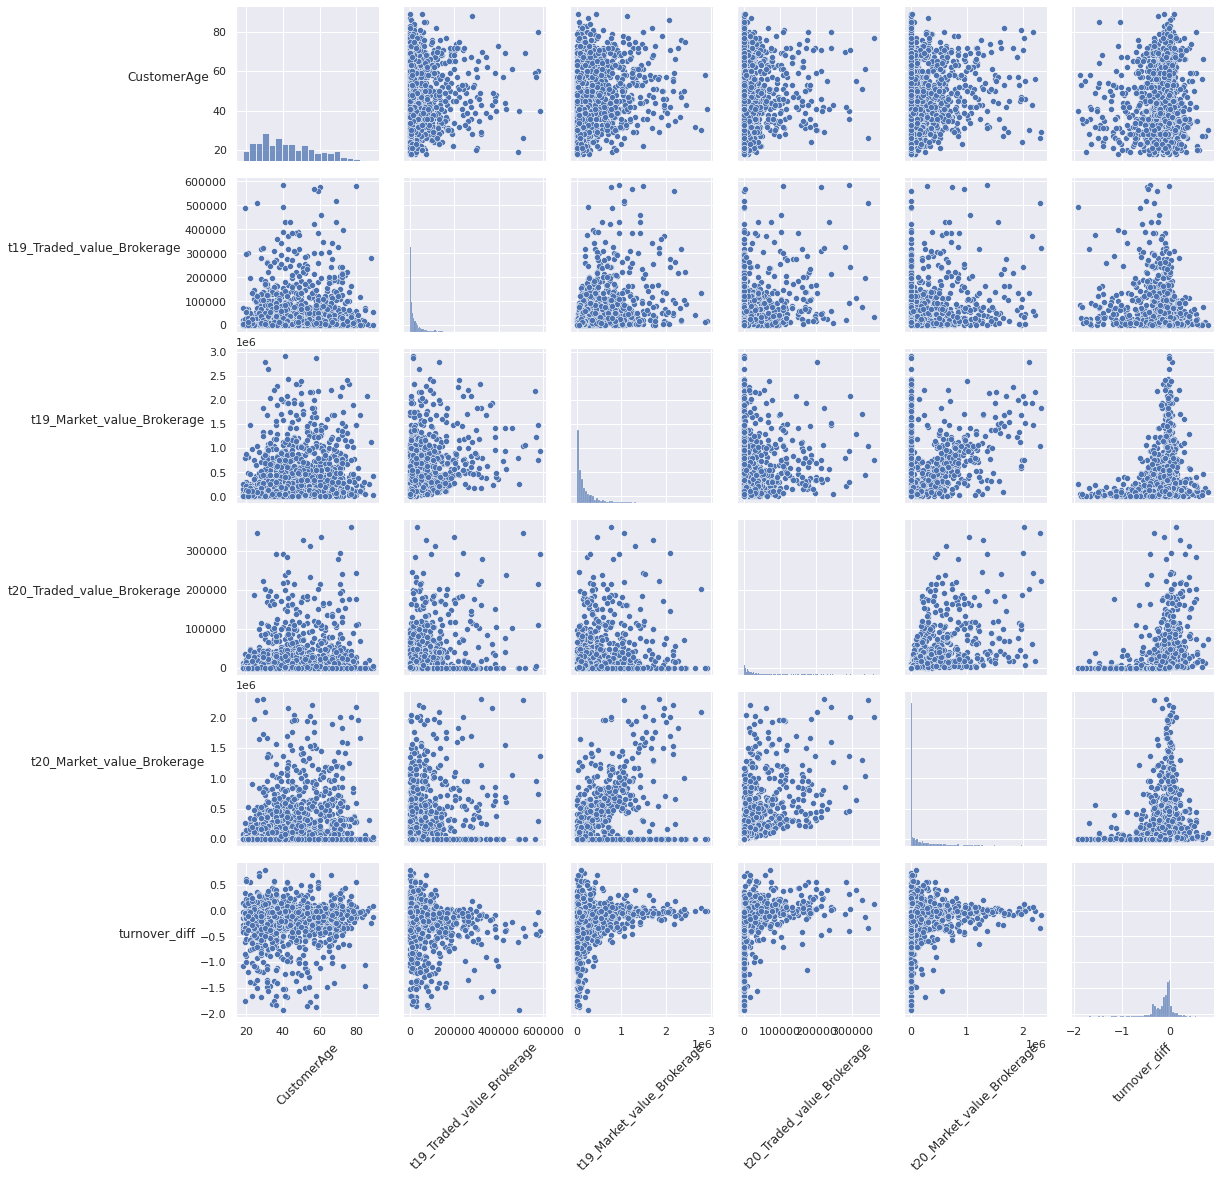

In [18]:
g = sns.pairplot(df)
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')


**Conclusion:**
* There is possibly a positive correlation between customer_age and turnover_diff. 
* Looking at t19_market_value_brokerage vs turnover_diff, people with a large portfolio tends to have a turnover_diff value close to zero. Their trading activities stay at the same level. 

<AxesSubplot:>

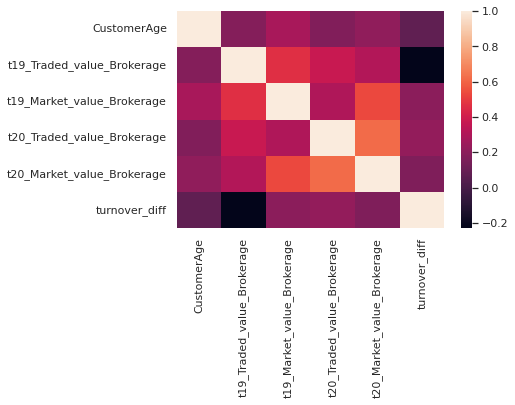

In [19]:
sns.heatmap(df.corr())

**Conclusion:** We use a heatmap to display the correlation between the numeric variables. By looking at the turnover_diff row, we don't see any feature that is positively correlated with it. 

## Building a linear model

A linear model has the equation, whereas x are the features, b is the error and y is the value to predict
<blockquote>y = w0 * x0 + w1 * x1 + ... + wn * x2 + b</blockquote>

We use **numeric features** as input: <br>
CustomerNumber, CustomerAge, t19_Traded_value_Brokerage, t19_Market_value_Brokerage, t20_Traded_value_Brokerage, t20_Market_value_Brokerage <br>

We also use **cateogrical features** as input. We preprocess the categorical features using OneHotEncoder <br>
CustomerCountry, CustomerGender, CustomerAge, CustomerDuration <br>

The **dependent variable** is **turnover_diff**

We want to see if there is any linear relationship between the input variables and the turnover_diff

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import metrics

In [21]:
df2 = pd.get_dummies(turnover_19_20)
X = df2.drop(["CustomerNumber", "turnover_2019", "turnover_2020", "turnover_diff"], axis=1)
y = df2["turnover_diff"]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

We take a look at our features and dependent variable

In [22]:
X_train.head()

,CustomerAge,t19_Traded_value_Brokerage,t19_Market_value_Brokerage,t20_Traded_value_Brokerage,t20_Market_value_Brokerage,CustomerCountry_DK,CustomerCountry_FI,CustomerCountry_NO,CustomerCountry_SE,CustomerGender_F,CustomerGender_M,CustomerDuration_1-3 years as customer,CustomerDuration_3+ years as customer,CustomerDuration_< 1 year as customer
7777,59,27685.12000,44731.70,11493.5130,61391.59,1,0,0,0,0,1,0,1,0
10955,48,16628.06775,95370.73,904.3932,66357.46,0,0,1,0,0,1,0,0,1
2652,61,2019.71000,1358515.60,0.0000,0.00,1,0,0,0,0,1,0,1,0
749,64,2134.95000,6870.50,0.0000,0.00,0,0,0,1,1,0,0,1,0
11866,28,2016.27000,3468.40,0.0000,0.00,0,1,0,0,0,1,0,0,1


In [23]:
y_train.head()

7777    -0.431699
10955   -0.160723
2652    -0.001487
749     -0.310742
11866   -0.581326
Name: turnover_diff, dtype: float64

In [24]:
lm = LinearRegression()
lm.fit(X_train,y_train)

coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
print(coeff_df.sort_values(by="Coefficient", ascending=False))

                                         Coefficient
CustomerCountry_NO                      3.144203e-02
CustomerDuration_3+ years as customer   2.099486e-02
CustomerDuration_1-3 years as customer  1.170550e-02
CustomerCountry_FI                      8.754036e-03
CustomerAge                             6.804240e-04
CustomerGender_F                        6.722720e-04
t20_Traded_value_Brokerage              2.381873e-06
t19_Market_value_Brokerage              2.418614e-07
t20_Market_value_Brokerage             -8.309400e-08
t19_Traded_value_Brokerage             -2.031837e-06
CustomerGender_M                       -6.722720e-04
CustomerCountry_SE                     -1.208537e-02
CustomerCountry_DK                     -2.811070e-02
CustomerDuration_< 1 year as customer  -3.270036e-02


If the model works, by ranking the coefficients of the model, we can **conclude with the following statements**: 
* Customers from Norway, who have been a customer for at least 1 year, tends to positivly contribute to turnover_diff. That is their turnover score of 2020 is better than that of 2019. 
* Customers that are male, from Sweden or Danmark, who have been with us for less than a year, tends to negatively contribute to turnover_diff. That is their turnover score of 2020 is worse than that of 2019. 


### How good is the model

We make predictions on the test set. And plot the predictions against the actual turnover score. If our linear model works, we should see such an graph. <br>
<img src="https://aws1.discourse-cdn.com/codecademy/optimized/5X/5/6/f/6/56f62009a7f3833b35aacdb68fed2b63959cd7f8_2_690x493.png" />

However, our model does not yield any good result

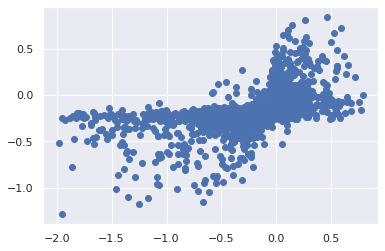

In [25]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)


In [26]:
print(turnover_19_20["turnover_diff"].describe())

count    13127.000000
mean        -0.165154
std          0.309177
min         -1.984484
25%         -0.266023
50%         -0.085191
75%         -0.011088
max          0.832534
Name: turnover_diff, dtype: float64


In [27]:
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MSE: 0.07378154492953701
RMSE: 0.2716275849937502


The training data has a standard deviation of 0.3092. The RMSE of the predicted value is 0.27. RMSE is almost as large as one standard deviation. Ouch! We need something better than a linear model. 

Copyright 2021
Author: Bowen Sui